In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
import seaborn as sns

# Learning curve optimization

Read data from training on WM grid:

In [2]:
data = pd.read_csv('data/final_data_cogmed_max_25min.csv', index_col=0)
accounts = data.treatmentid.unique()
data

,treatmentid,treatmentday,triallevel
5864846,208909,0.0,6.40
5864851,208909,1.0,5.85
5864856,208909,2.0,5.70
5864859,208909,3.0,6.00
5864864,208909,4.0,5.85
...,...,...,...
7949153,254388,12.0,7.70
7949159,254388,14.0,7.70
7949166,254388,16.0,6.95
7949173,254388,18.0,7.45


### 1.1 Run the optimization

In [45]:
def learning_curve(x, intercept, b_st, b_wm, a):
    """
    This is the function to be optimized 
    """
    return intercept + b_wm*x + b_st*np.tanh(a*x)

def plot_results(popt, time, level, i):
    
    t_switch = np.arctanh(0.99)/popt[3]
    
    ax = plt.subplot(1, 2, i)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=18)
    
    plt.plot(time, popt[0] + time*popt[2] + popt[1]*np.tanh(popt[3]*time), color="#d3494e", linewidth=3)  # 
    plt.scatter(time, level, facecolors='none', edgecolors="#3F5D7D", alpha=1, marker='o', linewidths=3)
    plt.xlabel('Training day', fontsize=20)
    plt.ylabel('Level', fontsize=20)
    
    plt.plot([t_switch, t_switch], [popt[0] + t_switch*popt[2] + popt[1]*np.tanh(popt[3]*t_switch), ax.get_ylim()[0]], color="#d3494e", linestyle='--', alpha=0.5, linewidth=3)
    plt.ylim(ax.get_ylim()[0] + 0.15, ax.get_ylim()[1])
    plt.xlim(0, 38)

def calc_prob_powerfunc(y_pred, y, sigma=0.7):
    """
    To compare tanh + lin with a single power function
    """
    return np.prod(1/(sigma*np.sqrt(2*np.pi))*np.exp(-1/(2*sigma**2) * (y_pred-y)**2))


### 1.2 Visualize for individual

6.78240325862785 1.423271657602012 0.021446163370113125 0.33000000000000007
4.364951017351623 1.1530680123491055 0.01639069536079363 0.3300000000000051


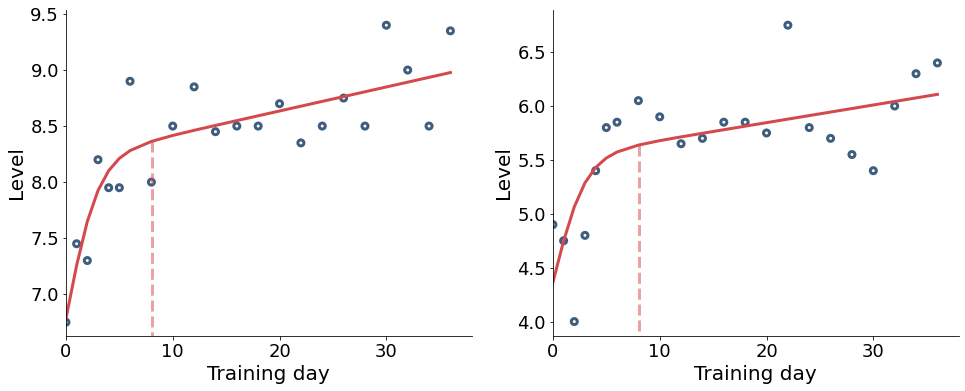

In [18]:
plt.figure(figsize=(16, 6)) 

user = 16  
response = data[data.treatmentid == accounts[user]]
time = response.treatmentday.values
level = response.triallevel.values
popt, pcov = curve_fit(learning_curve, time, level, maxfev=10000, bounds=([0.0, 0.0, -np.inf, 0.33], [np.inf, np.inf, 5., np.inf]))  # popt3: 0.5 - 4.0
plot_results(popt, time, level, 1)

print(popt[0], popt[1], popt[2], popt[3])
user = 5  
response = data[data.treatmentid == accounts[user]]
time = response.treatmentday.values
level = response.triallevel.values
popt, pcov = curve_fit(learning_curve, time, level, maxfev=10000, bounds=([0.0, 0.0, -np.inf, 0.33], [np.inf, np.inf, 5., np.inf]))  # popt3: 0.5 - 4.0
plot_results(popt, time, level, 2)
print(popt[0], popt[1], popt[2], popt[3])

plt.show()


### 1.3 Run algorithm for all subjects

Apart from the final parameter values, the covariance matrix for the levels on each day as well as AIC values are also saved.

In [31]:
nr_subjects = accounts.shape[0]
popt0 = np.zeros(nr_subjects)
popt1 = np.zeros(nr_subjects)
popt2 = np.zeros(nr_subjects)
popt3 = np.zeros(nr_subjects)
aics = []

covariance_mat = np.zeros((20, 20))
count3 = 0

for user in range(nr_subjects):
    response = data[data.treatmentid == accounts[user]]
    time = response.treatmentday.values[:20]
    level = response.triallevel.values[:20]
    try:
        popt, pcov = curve_fit(learning_curve, time, level, maxfev=20000, p0=[5, 0.6, 0.06, 1], bounds=([0.0, 0.0, -np.inf, 0.33], [np.inf, np.inf, np.inf, np.inf]))
        popt0[user] = popt[0]
        popt1[user] = popt[1]
        popt2[user] = popt[2]
        popt3[user] = popt[3]
        
        prob = calc_prob_powerfunc(popt[0] + time*popt[2] + popt[1]*np.tanh(popt[3]*time), level)
        aic = 2*4 - 2*np.log(np.sum(prob))
        aics.append(aic)
        if time.shape[0] == 20:
            e = np.zeros((20, 1))
            e[:,0] = level - popt[0] - time*popt[2] - popt[1]*np.tanh(popt[3]*time)
            count3 += 1
            covariance_mat += np.dot(e, e.T)       
    except:
        pass
    

Create and save covariance matrix

In [31]:
cov = pd.DataFrame(np.around(covariance_mat/(count3-2), decimals=2))
cov.to_excel('cov_matrix_tanh.xlsx')

Remove data for subjects where the probabilities were numerically too small for the EM algorithm:

In [32]:
idx = np.where(popt0 != 0)[0]
popt0 = popt0[idx]
popt1 = popt1[idx]
popt2 = popt2[idx]
popt3 = popt3[idx]
aics = np.array(aics)
aics = aics[~np.isnan(aics)]

In [44]:
tau_mean = np.nanmedian(popt3) 
a1 = np.nanmedian(popt0) 
b1 = np.nanmedian(popt1)
b2 = np.nanmedian(popt2)
print(b1)
print(b2)
print(tau_mean)
print(a1)

0.6959000927194978
0.010858536160860266
0.4608168862265783
5.350000000000003


### 1. 4 Save results

In [33]:
results_df = pd.DataFrame(index=accounts, data={'intercept': popt0, 'slope1': popt1, 'slope2': popt2, 'tau': popt3}) # 
results_df.to_csv('data/HMM_slopes_tanh2.csv')

# 2. CFA comparision

### 2.1 Create dataframe including both learning curve and CFA values

In [34]:
results_df = pd.read_csv('data/HMM_slopes_tanh2.csv', index_col=0)
results_df

,intercept,slope1,slope2,tau
208909,6.033957,0.046169,0.007002,0.330000
208996,5.561042,0.539785,-0.011567,0.424967
209052,4.002309,1.448969,-0.002966,0.380507
209183,4.575341,0.802808,0.015274,0.330000
209193,5.950015,0.110759,0.009947,10.027340
...,...,...,...,...
253783,5.614299,0.958708,0.037832,0.717830
253920,4.252075,1.500093,-0.069914,0.330000
254361,5.433375,1.253463,0.048277,0.330000
254379,6.361099,0.714505,-0.009242,0.330000


In [35]:
test_data = pd.read_csv('fscores_cogmed_25_9to11_2factors.csv', index_col=0) # fscores_cogmed_25_9to11_2factors.csv
test_data_info = pd.read_csv('data/test_data_max_long_25min.csv', index_col=0)
test_data.index = test_data_info.index
test_data

,factor2,factor3,factor4,factor5,factor6,factor22,factor32,factor42,factor52,factor62
208909,-0.212121,-0.386241,-0.210690,-0.044718,0.360330,1.221812,0.209600,1.309062,0.884245,0.949346
208996,-0.094633,0.122923,0.435866,0.523262,0.910307,0.363719,0.399203,0.566038,-0.121153,-0.778365
209052,-0.850632,-0.834953,-0.630472,-0.512722,-0.100993,-0.810493,0.149304,0.548539,-0.133013,0.237918
209183,-1.294203,-1.239499,-1.074591,-1.044818,-0.801206,0.008906,0.849707,0.926505,1.727955,-2.911312
209193,-0.010703,-0.073705,0.139322,0.418003,0.753296,0.533519,0.789161,1.063859,0.874632,0.640979
...,...,...,...,...,...,...,...,...,...,...
253070,0.389844,0.642759,0.938837,1.127696,1.414540,0.160288,1.051754,0.436467,-0.094683,0.534497
253192,-0.600162,-0.302827,0.076166,0.209832,0.526016,-0.123313,0.733295,1.172334,0.006970,0.097029
253232,0.015788,0.182473,0.322952,0.306174,0.749014,0.041409,1.501320,-1.377933,0.019742,-0.533965
253503,0.013999,0.272608,0.605413,0.810424,1.089877,0.101728,0.723607,0.462449,0.831811,0.276703


This creates one measure for strategy

In [36]:
test_data['diff_strat'] = test_data['factor32'] - test_data['factor22']
test_data = test_data.drop(columns = ['factor22', 'factor32'])
test_data

,factor2,factor3,factor4,factor5,factor6,factor42,factor52,factor62,diff_strat
208909,-0.212121,-0.386241,-0.210690,-0.044718,0.360330,1.309062,0.884245,0.949346,-1.012212
208996,-0.094633,0.122923,0.435866,0.523262,0.910307,0.566038,-0.121153,-0.778365,0.035484
209052,-0.850632,-0.834953,-0.630472,-0.512722,-0.100993,0.548539,-0.133013,0.237918,0.959798
209183,-1.294203,-1.239499,-1.074591,-1.044818,-0.801206,0.926505,1.727955,-2.911312,0.840801
209193,-0.010703,-0.073705,0.139322,0.418003,0.753296,1.063859,0.874632,0.640979,0.255642
...,...,...,...,...,...,...,...,...,...
253070,0.389844,0.642759,0.938837,1.127696,1.414540,0.436467,-0.094683,0.534497,0.891466
253192,-0.600162,-0.302827,0.076166,0.209832,0.526016,1.172334,0.006970,0.097029,0.856608
253232,0.015788,0.182473,0.322952,0.306174,0.749014,-1.377933,0.019742,-0.533965,1.459911
253503,0.013999,0.272608,0.605413,0.810424,1.089877,0.462449,0.831811,0.276703,0.621879


The capacity slope is calculated using linear regression. 

In [37]:
slopes = []
times = [2, 10, 20, 30, 40]
for user in test_data.index:
    response = test_data.loc[user]
    response = response[['factor2', 'factor3', 'factor4', 'factor5', 'factor6']]
    res = linregress(times, response.values)
    slopes.append(res.slope)
test_data['diff_wm'] = slopes
test_data = test_data[['diff_strat', 'diff_wm']] 

In [38]:
results_df = results_df.join(test_data)
results_df = results_df.dropna()
results_df

,intercept,slope1,slope2,tau,diff_strat,diff_wm
208909,6.033957,0.046169,0.007002,0.330000,-1.012212,0.015855
208996,5.561042,0.539785,-0.011567,0.424967,0.035484,0.025080
209052,4.002309,1.448969,-0.002966,0.380507,0.959798,0.019157
209183,4.575341,0.802808,0.015274,0.330000,0.840801,0.012348
209193,5.950015,0.110759,0.009947,10.027340,0.255642,0.021323
...,...,...,...,...,...,...
253070,5.900511,0.905812,-0.019805,1.234662,0.891466,0.026340
253192,4.717292,1.375330,-0.001554,0.330000,0.856608,0.028690
253232,5.531309,1.172286,-0.036176,0.384944,1.459911,0.016576
253503,5.600000,0.376568,0.031282,12.465981,0.621879,0.027954


In [39]:
results_df['day'] = np.arctanh(0.99)/results_df['tau']

### 1. 2 Visualize distributions

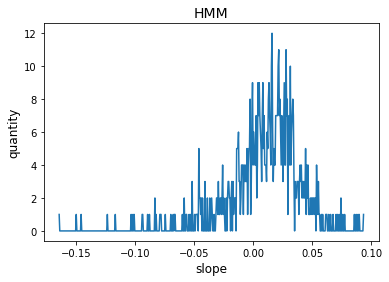

0.7301534189276788


In [49]:
hist = np.histogram(results_df.slope2, bins=500)
plt.plot(hist[1][1:], hist[0][:])
plt.title('HMM', fontsize=14)
plt.xlabel('slope', fontsize=12)
plt.ylabel('quantity', fontsize=12)
plt.show()
print(np.median(results_df.day))

/Users/julia.ericson/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/julia.ericson/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


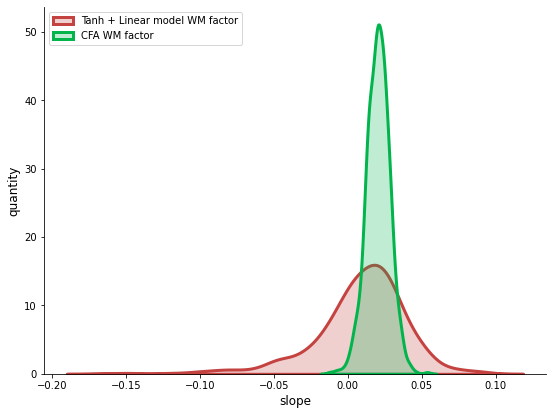

0.020407596538599027


In [50]:
plt.figure(figsize=(9, 6.75)) 
ax = plt.subplot(1, 1, 1)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)

sns.distplot(results_df.slope2, hist=False, kde=True, bins=int(180/5), color="#c44240", 
             hist_kws={'edgecolor':'black'}, kde_kws={'shade': True,'linewidth': 3}, label='Tanh + Linear model WM factor')

sns.distplot(results_df.diff_wm*0.77, hist=False, kde=True, bins=int(180/5), color="#01b44c", 
             hist_kws={'edgecolor':'black'}, kde_kws={'shade': True,'linewidth': 3}, label='CFA WM factor')

plt.xlabel('slope', fontsize=12)
plt.ylabel('quantity', fontsize=12)
plt.legend(loc='upper left')

plt.show()
print(np.median(results_df.diff_wm*0.77))

### 1.3 Look at correlations

In [41]:
correlations = results_df.corr()
correlations

,intercept,slope1,slope2,tau,diff_strat,diff_wm,day
intercept,1.000000,-0.266503,0.067680,0.000847,-0.276848,0.292806,0.058130
slope1,-0.266503,1.000000,-0.299039,-0.315194,0.761838,0.208137,0.345554
slope2,0.067680,-0.299039,1.000000,0.059707,-0.024362,0.543019,-0.090212
tau,0.000847,-0.315194,0.059707,1.000000,-0.214852,-0.069725,-0.811128
diff_strat,-0.276848,0.761838,-0.024362,-0.214852,1.000000,0.207250,0.195406
diff_wm,0.292806,0.208137,0.543019,-0.069725,0.207250,1.000000,0.070857
day,0.058130,0.345554,-0.090212,-0.811128,0.195406,0.070857,1.000000


### Visualize tanh function

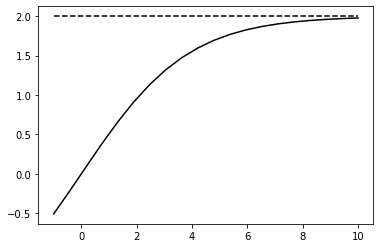

In [280]:
x = np.linspace(-1, 10, 20)
y = 2*np.tanh(0.26*x)
plt.plot(x, y, color='black')
plt.plot(x, 2*np.ones_like(x), '--', color='black')
plt.show()

In [236]:
pd.set_option('display.min_rows', 500)

In [47]:
np.arctanh(0.99)/5.88

0.4501109544833751